In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from pmdarima.arima import auto_arima
import scipy as spicy

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../Data/S&P500_Project.csv', index_col='date', parse_dates=True)
df

,close
date,
1986-01-01,210.880000
1986-02-01,212.790000
1986-03-01,224.380000
1986-04-01,228.690000
1986-05-01,234.790000
...,...
2020-07-01,3130.010010
2020-08-01,3306.510010
2020-09-01,3426.959961


In [3]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 16

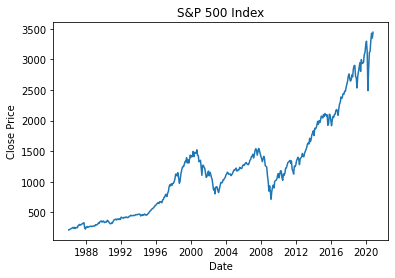

In [4]:

plt.plot(df['close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('S&P 500 Index')
plt.show()

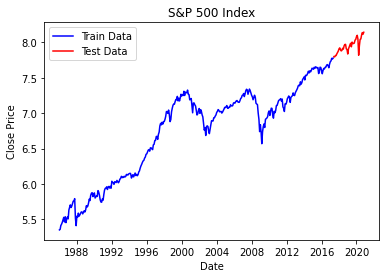

In [5]:
df_close = np.log(df['close'])
train_data, test_data = df_close[:int(len(df_close)*0.9)], df_close[int(len(df_close)*0.9):]
plt.plot(train_data, 'blue', label='Train Data')
plt.plot(test_data, 'red', label='Test Data')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.title('S&P 500 Index')
plt.show()


In [6]:
df_close

date
1986-01-01    5.351289
1986-02-01    5.360306
1986-03-01    5.413341
1986-04-01    5.432367
1986-05-01    5.458691
                ...   
2020-07-01    8.048791
2020-08-01    8.103649
2020-09-01    8.139429
2020-10-01    8.116244
2020-11-01    8.144226
Name: close, Length: 419, dtype: float64

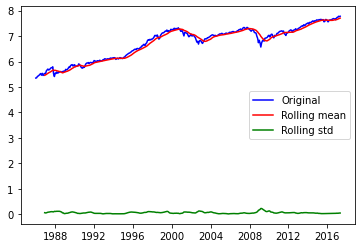

In [7]:
#Biểu đồ lịch sử so sánh giá đóng cửa với giá trị trung bình và độ lệch chuẩn của 12 kỳ trước đó
rolmean = train_data.rolling(12).mean()     
rolstd = train_data.rolling(12).std() #Độ lệch chuẩn: Độ giao động so với lịch sử giá trong quá khứ
plt.plot(train_data, 'blue', label='Original')
plt.plot(rolmean, 'red', label='Rolling mean')
plt.plot(rolstd, 'green', label='Rolling std')
plt.legend()
plt.show()

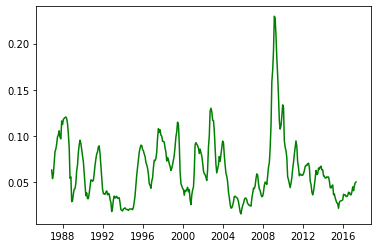

In [8]:
plt.plot(rolstd, 'green', label='Rolling std')
plt.show()

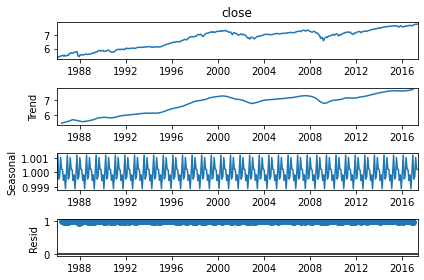

In [9]:
#Biểu đồ phân rã kiểu thời gian (decompose)
decompose_results = seasonal_decompose(train_data , model='multiplicative', period=10)
decompose_results.plot()
plt.show()

In [10]:
#Kiểm định tính dừng của dữ liệu
def adf_test(data):
    indices = ["ADF: Test statistic", "p values", "# of lags", "# of Observations"]
    test = adfuller(data, autolag='AIC')
    results = pd.Series(test[:4], index=indices)
    for key, value in test[4].items():
        results[f'Critical value: ({key})']=value
    return results

def kpss_test(data):
    indices = ["KPSS: Test statistic", "p values", "# of lags"]
    test = kpss(data)
    results = pd.Series(test[:3], index=indices)
    for key, value in test[3].items():
        results[f'Critical value: ({key})']=value
    return results


In [11]:
print(adf_test(train_data))
print('---------')
print(kpss_test(train_data))

ADF: Test statistic       -1.408125
p values                   0.578375
# of lags                  0.000000
# of Observations        376.000000
Critical value: (1%)      -3.447862
Critical value: (5%)      -2.869258
Critical value: (10%)     -2.570881
dtype: float64
---------
KPSS: Test statistic       2.789819
p values                   0.010000
# of lags                 11.000000
Critical value: (10%)      0.347000
Critical value: (5%)       0.463000
Critical value: (2.5%)     0.574000
Critical value: (1%)       0.739000
dtype: float64


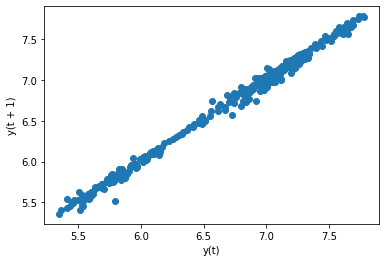

In [12]:
pd.plotting.lag_plot(train_data)
plt.show()

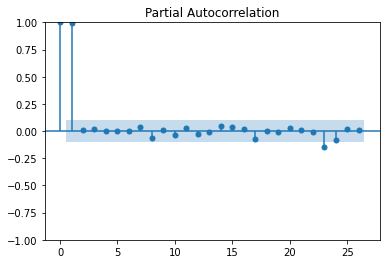

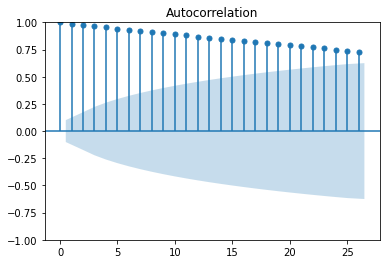

In [13]:

plot_pacf(train_data)
plt.show()
plot_acf(train_data)
plt.show()

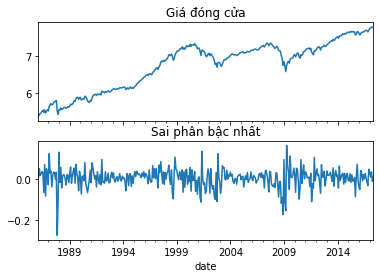

In [14]:
#CHuyển đổi chuổi dừng
# Tính sai phân bậc 1 dữ liệu train
diff = train_data.diff(1).dropna()
# Biểu đồ thể hiện dữ liệu ban đầu và sau khi lấy sai phân
fig, ax = plt.subplots(2, sharex='all')
train_data.plot(ax=ax[0], title='Giá đóng cửa')
diff.plot(ax=ax[1], title='Sai phân bậc nhất')
plt.show()

ADF: Test statistic      -20.023857
p values                   0.000000
# of lags                  0.000000
# of Observations        375.000000
Critical value: (1%)      -3.447909
Critical value: (5%)      -2.869278
Critical value: (10%)     -2.570892
dtype: float64
KPSS: Test statistic      0.129294
p values                  0.100000
# of lags                 0.000000
Critical value: (10%)     0.347000
Critical value: (5%)      0.463000
Critical value: (2.5%)    0.574000
Critical value: (1%)      0.739000
dtype: float64


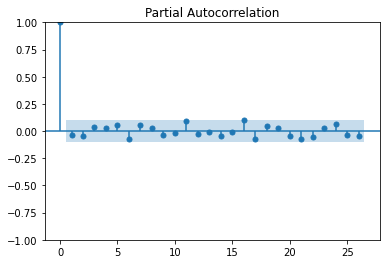

In [15]:
print(adf_test(diff))
print(kpss_test(diff))
plot_pacf(diff) # có thể xác định tham số "p" cho mô hình Arima
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1230.739, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1233.344, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1231.834, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1231.879, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1228.221, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1230.033, Time=0.59 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.874 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  377
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 618.672
Date:                Thu, 11 Aug 2022   AIC                          -1233.344
Time:                        11:43:32   BIC                          -1225.485
Sample:                             0   HQIC                         -1230.224
    

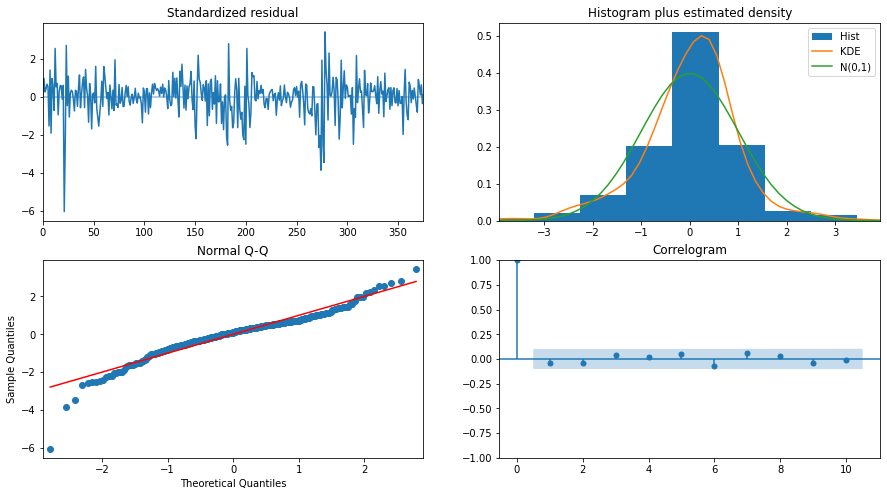

In [16]:
# Xác định tham số p, d, q cho mô hình ARIMA
stepwise_fit = auto_arima(train_data, trace=True, suppress_warning=True)
print(stepwise_fit.summary())
stepwise_fit.plot_diagnostics(figsize=(15,8))
plt.show()

In [17]:
# Tajo model
model = ARIMA(train_data, order=(0,1,0), trend='t')
fitted = model.fit()
print(fitted.summary())


# model = ARIMA(train_data, order=(1, 1, 2))
# fitted = model(index=test_data.index).fit()
# print(fitted.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  377
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 618.672
Date:                Thu, 11 Aug 2022   AIC                          -1233.344
Time:                        11:43:33   BIC                          -1225.485
Sample:                    01-01-1986   HQIC                         -1230.224
                         - 05-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0065      0.003      2.513      0.012       0.001       0.011
sigma2         0.0022   9.42e-05     23.132      0.000       0.002       0.002
Ljung-Box (L1) (Q):                   0.49   Jarque-

In [18]:
# Forcast
fc = fitted.forecast(len(test_data), alpha=0.05, index=test_data.index)
se = fitted.bse
conf = fitted.get_forecast(len(test_data), alpha=0.05, index=test_data.index).conf_int()
# print(type(fc))


In [19]:
print(fc, se, conf)

date
2017-06-01    7.785299
2017-07-01    7.791750
2017-08-01    7.798202
2017-09-01    7.804653
2017-10-01    7.811104
2017-11-01    7.817555
2017-12-01    7.824007
2018-01-01    7.830458
2018-02-01    7.836909
2018-03-01    7.843360
2018-04-01    7.849812
2018-05-01    7.856263
2018-06-01    7.862714
2018-07-01    7.869165
2018-08-01    7.875617
2018-09-01    7.882068
2018-10-01    7.888519
2018-11-01    7.894971
2018-12-01    7.901422
2019-01-01    7.907873
2019-02-01    7.914324
2019-03-01    7.920776
2019-04-01    7.927227
2019-05-01    7.933678
2019-06-01    7.940129
2019-07-01    7.946581
2019-08-01    7.953032
2019-09-01    7.959483
2019-10-01    7.965934
2019-11-01    7.972386
2019-12-01    7.978837
2020-01-01    7.985288
2020-02-01    7.991739
2020-03-01    7.998191
2020-04-01    8.004642
2020-05-01    8.011093
2020-06-01    8.017545
2020-07-01    8.023996
2020-08-01    8.030447
2020-09-01    8.036898
2020-10-01    8.043350
2020-11-01    8.049801
Name: predicted_mean, dtype: 

In [20]:

lower_series = pd.Series(conf['lower close'], index=test_data.index)
upper_series = pd.Series(conf['upper close'], index=test_data.index)
# print(lower_series)


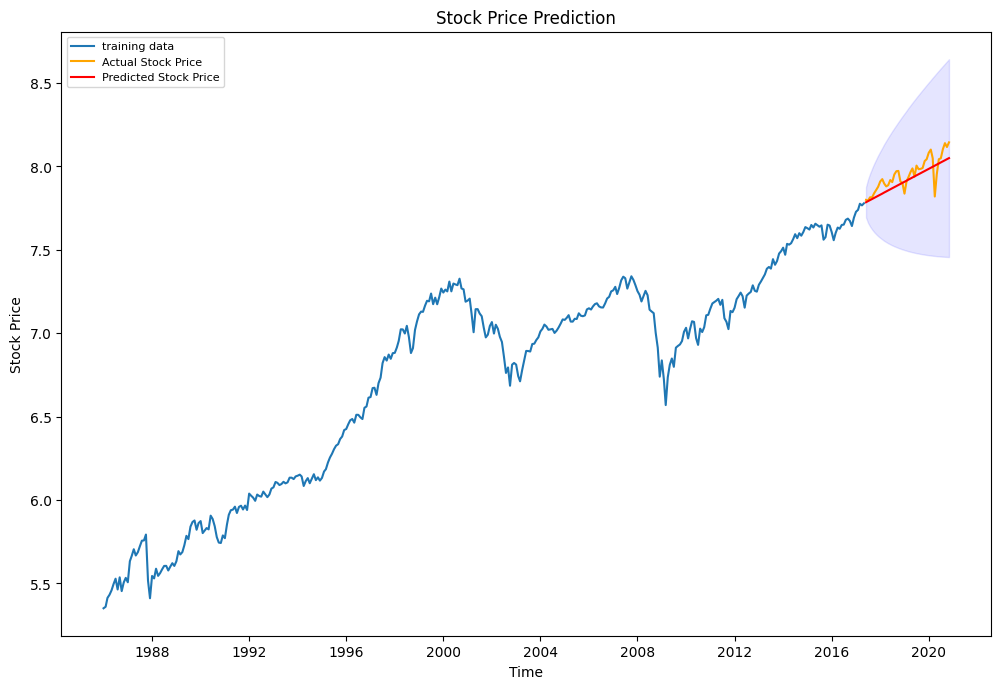

In [21]:
plt.figure(figsize=(12,8), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'orange', label='Actual Stock Price')
plt.plot(fc, color = 'red',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='b', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [22]:
ma_month = [10, 20, 50]

for ma in ma_month:
    column_name = f"MA for {ma} months"
    df[column_name] = df['close'].rolling(ma).mean()

Text(0.5, 1.0, 'S&P 500')

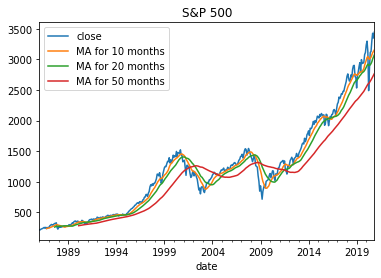

In [23]:
df[['close', 'MA for 10 months', 'MA for 20 months', 'MA for 50 months']].plot().set_title('S&P 500')

In [24]:
def lag_view(x, order):
    """
    For every value X_i create a row that lags k values: [X_i-1, X_i-2, ... X_i-k]
    """
    y = x.copy()
    # Create features by shifting the window of `order` size by one step.
    # This results in a 2D array [[t1, t2, t3], [t2, t3, t4], ... [t_k-2, t_k-1, t_k]]
    x = np.array([y[-(i + order):][:order] for i in range(y.shape[0])])
    
    # Reverse the array as we started at the end and remove duplicates.
    # Note that we truncate the features [order -1:] and the labels [order]
    # This is the shifting of the features with one time step compared to the labels
    x = np.stack(x)[::-1][order - 1: -1]
    y = y[order:]

    return x, y

In [25]:
def lag_view(x, order):
    y = x.copy()
    x = np.array([y[-(i + order):][:order] for i in range(y.shape[0])])
    x = np.stack(x)[::-1][order - 1: -1]
    y = y[order:]

    return x, y

In [26]:
def ma_process(eps, theta):
    """
    Creates an MA(q) process with a zero mean (mean not included in implementation).
    :param eps: (array) White noise signal.
    :param theta: (array/ list) Parameters of the process.
    """
    # reverse the order of theta as Xt, Xt-1, Xt-k in an array is Xt-k, Xt-1, Xt.
    theta = np.array([1] + list(theta))[::-1][:, None]
    eps_q, _ = lag_view(eps, len(theta))
    return eps_q @ theta


i = 0

theta = np.random.uniform(0, 1, size=i + 1)

arr = ma_process(train_data, theta)
arrtest = ma_process(test_data, theta)
test_data = test_data.drop(['2017-06-01', '2017-07-01'])
train_data = train_data.drop(['1986-01-01', '1986-02-01'])




In [27]:
my_list = map(lambda x: x[0], arr)
ser = pd.Series(my_list, index=train_data.index)
my_list1 = map(lambda y: y[0], arrtest)
ser1 = pd.Series(my_list1, index=test_data.index)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


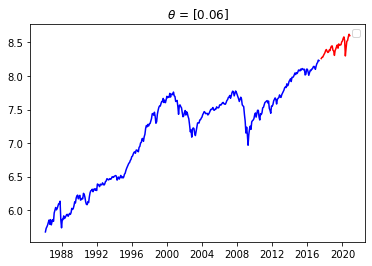

In [28]:
plt.title(f'$\\theta$ = {theta.round(2)}')
plt.plot(ser, color='blue')
plt.plot(ser1, color='red')
plt.legend()

In [29]:
def ma_process(eps, theta):
    theta = np.array([1] + list(theta))[::-1][:, None]
    eps_q, _ = lag_view(eps, len(theta))
    return eps_q @ theta

In [30]:
mod = ARIMA(train_data, order=(0, 0, 1))
res = mod.fit()
# Print out summary information on the fit
print(res.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  375
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -129.422
Date:                Thu, 11 Aug 2022   AIC                            264.845
Time:                        11:43:41   BIC                            276.625
Sample:                    03-01-1986   HQIC                           269.522
                         - 05-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7462      0.040    170.197      0.000       6.669       6.824
ma.L1          0.9557      0.019     49.637      0.000       0.918       0.993
sigma2         0.1160      0.013      8.877      0.0

In [31]:
# save model
import pickle
with open('./models/model_TimeSeries_ARIMA_S&P500', 'wb') as f:
    pickle.dump(model, f)
with open('./models/model_TimeSeries_MA_S&P500', 'wb') as f:
    pickle.dump(mod, f)